In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import feature.experimental_dataset as experimental_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import plot.plot_motifs as plot_motifs
import analysis.motif_util as motif_util
import os
import json
import torch
import numpy as np
import scipy.stats
import pyBigWig
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import logomaker
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
datasets = [
    "CTCF (HepG2)", "FOXA1 (HepG2)", "MAX (HepG2)", "DNase (HepG2)", "DNase (K562)"
]

In [6]:
datasets_sanit = {
    dataset_key : dataset_key.replace("/", "_").replace(" ", "").replace("(", "_").replace(")", "").lower()
    for dataset_key in datasets
}

In [7]:
model_paths = {
    "CTCF (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/mechint_net/1/last_ckpt.pth"),
    "FOXA1 (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/mechint_net/3/last_ckpt.pth"),
    "MAX (HepG2)": os.path.join(base_path, "models/trained_models/experimental/chipseq_max_hepg2/mechint_net/2/last_ckpt.pth"),
    "DNase (HepG2)": os.path.join(base_path, "models/trained_models/experimental/dnase_hepg2/mechint_net/3/last_ckpt.pth"),
    "DNase (HL-60)": os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/mechint_net/3/last_ckpt.pth"),
    "DNase (K562)": os.path.join(base_path, "models/trained_models/experimental/dnase_k562/mechint_net/1/last_ckpt.pth")
}

In [8]:
peak_bed_paths = {
    "CTCF (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF664UGR_idrpeaks.bed.gz"),
    "FOXA1 (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF081USG_idrpeaks.bed.gz"),
    "MAX (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR168DYA_MAX_HepG2/ENCFF254ZDA_idrpeaks.bed.gz"),
    "DNase (HepG2)": os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF897NME_peaks.bed.gz"),
    "DNase (HL-60)": os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF773SFA_peaks.bed.gz"),
    "DNase (K562)": os.path.join(base_path, "data/encode/dnase/ENCSR000EKS_K562/ENCFF274YGF_peaks.bed.gz")
}

In [9]:
profile_bigwig_paths = {
    "CTCF (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF938HDS_profile.bw"),
    "FOXA1 (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF943NCT_profile.bw"),
    "MAX (HepG2)": os.path.join(base_path, "data/encode/chipseq/ENCSR168DYA_MAX_HepG2/ENCFF040STV_profile.bw"),
    "DNase (HepG2)": os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF113VII_profile.bw"),
    "DNase (HL-60)": os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF631GRN_profile.bw"),
    "DNase (K562)": os.path.join(base_path, "data/encode/dnase/ENCSR000EKS_K562/ENCFF972GVB_profile.bw")
}

In [10]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/attention_scores_peaks"
os.makedirs(figures_out_path, exist_ok=True)

### Run forward predictions

In [11]:
# For each dataset, create a data loader and use it to extract inputs, activations, and attention scores
all_input_seqs = {}
all_input_coords = {}
all_conv_acts, all_att_vals = {}, {}
all_pfms, all_filter_widths = {}, {}
pfm_max_thresh_frac = 0.5
for dataset_key in tqdm.notebook.tqdm(datasets):
    # Create dataloader
    data_loader = experimental_dataset.dataset_ex.run(
        "create_data_loader", config_updates={
            "peaks_bed_path": peak_bed_paths[dataset_key],
            # "input_center_overlap": -1,  # Output peak-centered coordinates
            "batch_size": 128,
            "negative_ratio": 0,  # No negatives
            "chrom_set": ["chr1"],  # Test set
            "revcomp": False,  # No reverse complementation
            "return_coords": True
        }
    ).result
    data_loader.dataset.on_epoch_start()

    # Import model
    model = model_util.load_model(
        mechint_net.MechIntRegNet, model_paths[dataset_key]
    ).to(DEVICE)

    # Run forward pass to extract inputs, activations, and attention scores
    _, _, model_outputs, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    one_hots = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = one_hots.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * pfm_max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = one_hots[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    # Save sequences, activations, attention values, constructed PFMs, and true coordinates
    all_input_seqs[dataset_key] = one_hots
    all_conv_acts[dataset_key] = conv_acts
    all_att_vals[dataset_key] = model_outputs_other["att_vals"]  # Shape: N x AL x NH x L'
    all_pfms[dataset_key] = pfms
    all_input_coords[dataset_key] = input_data[2]
    all_filter_widths[dataset_key] = filter_width

  0%|          | 0/5 [00:00<?, ?it/s]

WARNING - root - Added new config entry: "chrom_set"
WARNING - root - Added new config entry: "peaks_bed_path"
WARNING - root - Added new config entry: "return_coords"
WARNING - exp_dataset - No observers have been added to this run
INFO - exp_dataset - Running command 'create_data_loader'
INFO - exp_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - exp_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x15380f5159a0>
INFO - exp_dataset - Completed after 0:00:00

	Loss: 0.7086: 100%|████████████████

### Show PFMs

In [12]:
# Filter PFMs/filters for high-quality motifs
min_average_ic = 1.0
min_length = 5
all_passed_pfms = {}
for dataset_key in datasets:
    pfms = all_pfms[dataset_key]
    
    # Trim by IC
    trimmed_pfms = {i : motif_util.trim_motif_by_low_ic(pfm, motif_util.pfm_info_content(pfm)) for i, pfm in enumerate(pfms)}

    # Require trimmed length to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if len(pfm) >= min_length}

    # Require total IC to be at least minimum
    trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if np.mean(motif_util.pfm_info_content(pfm)) >= min_average_ic}

    print(dataset_key)
    print("Total passed PFMs: %d" % len(trimmed_pfms))
    print("PFM lengths", {i : len(pfm) for i, pfm in trimmed_pfms.items()})
    print()
    
    all_passed_pfms[dataset_key] = trimmed_pfms

CTCF (HepG2)
Total passed PFMs: 3
PFM lengths {5: 15, 6: 14, 7: 13}

FOXA1 (HepG2)
Total passed PFMs: 6
PFM lengths {1: 14, 2: 8, 3: 12, 5: 15, 6: 11, 7: 11}

MAX (HepG2)
Total passed PFMs: 2
PFM lengths {3: 15, 7: 15}

DNase (HepG2)
Total passed PFMs: 6
PFM lengths {1: 12, 2: 8, 13: 9, 15: 13, 16: 14, 17: 12}

DNase (K562)
Total passed PFMs: 6
PFM lengths {8: 10, 9: 12, 12: 15, 14: 7, 16: 15, 17: 14}



CTCF (HepG2)


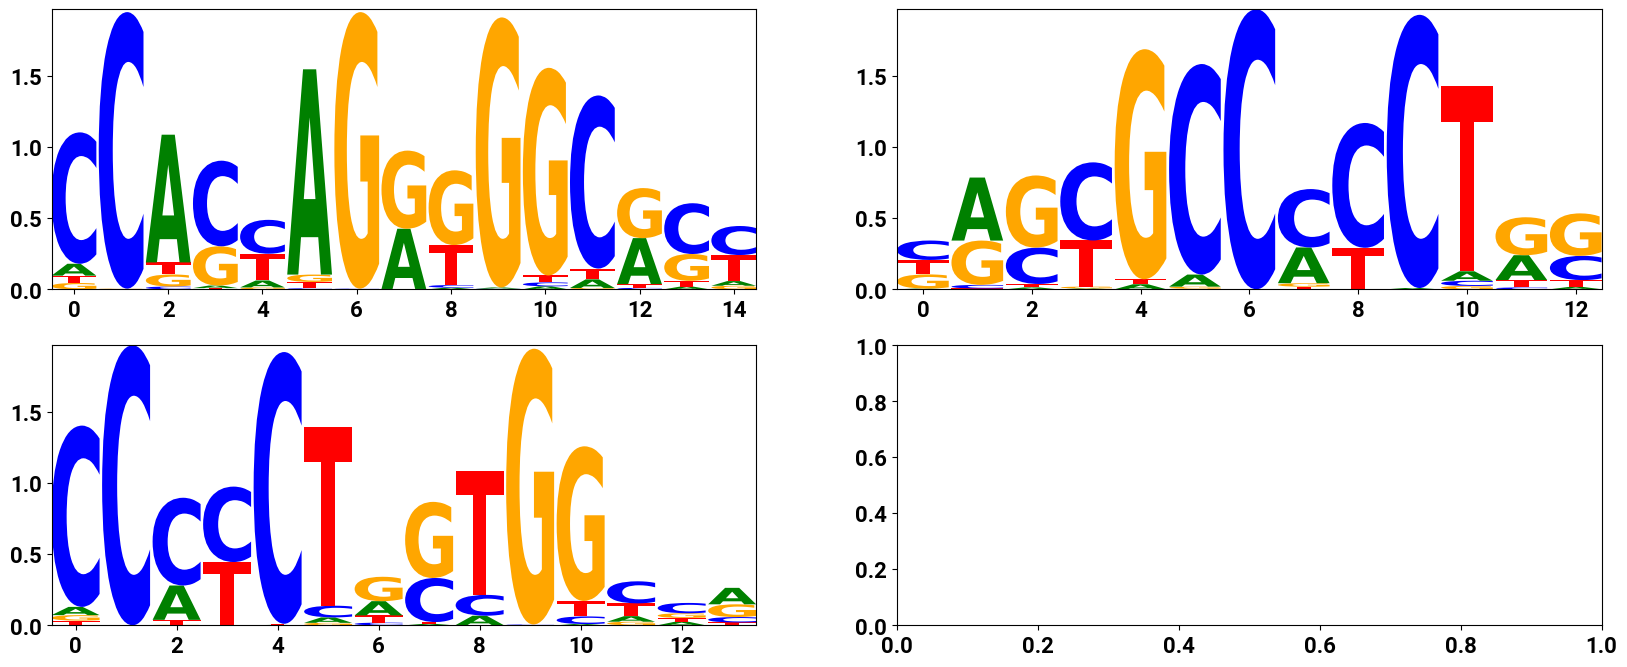

FOXA1 (HepG2)


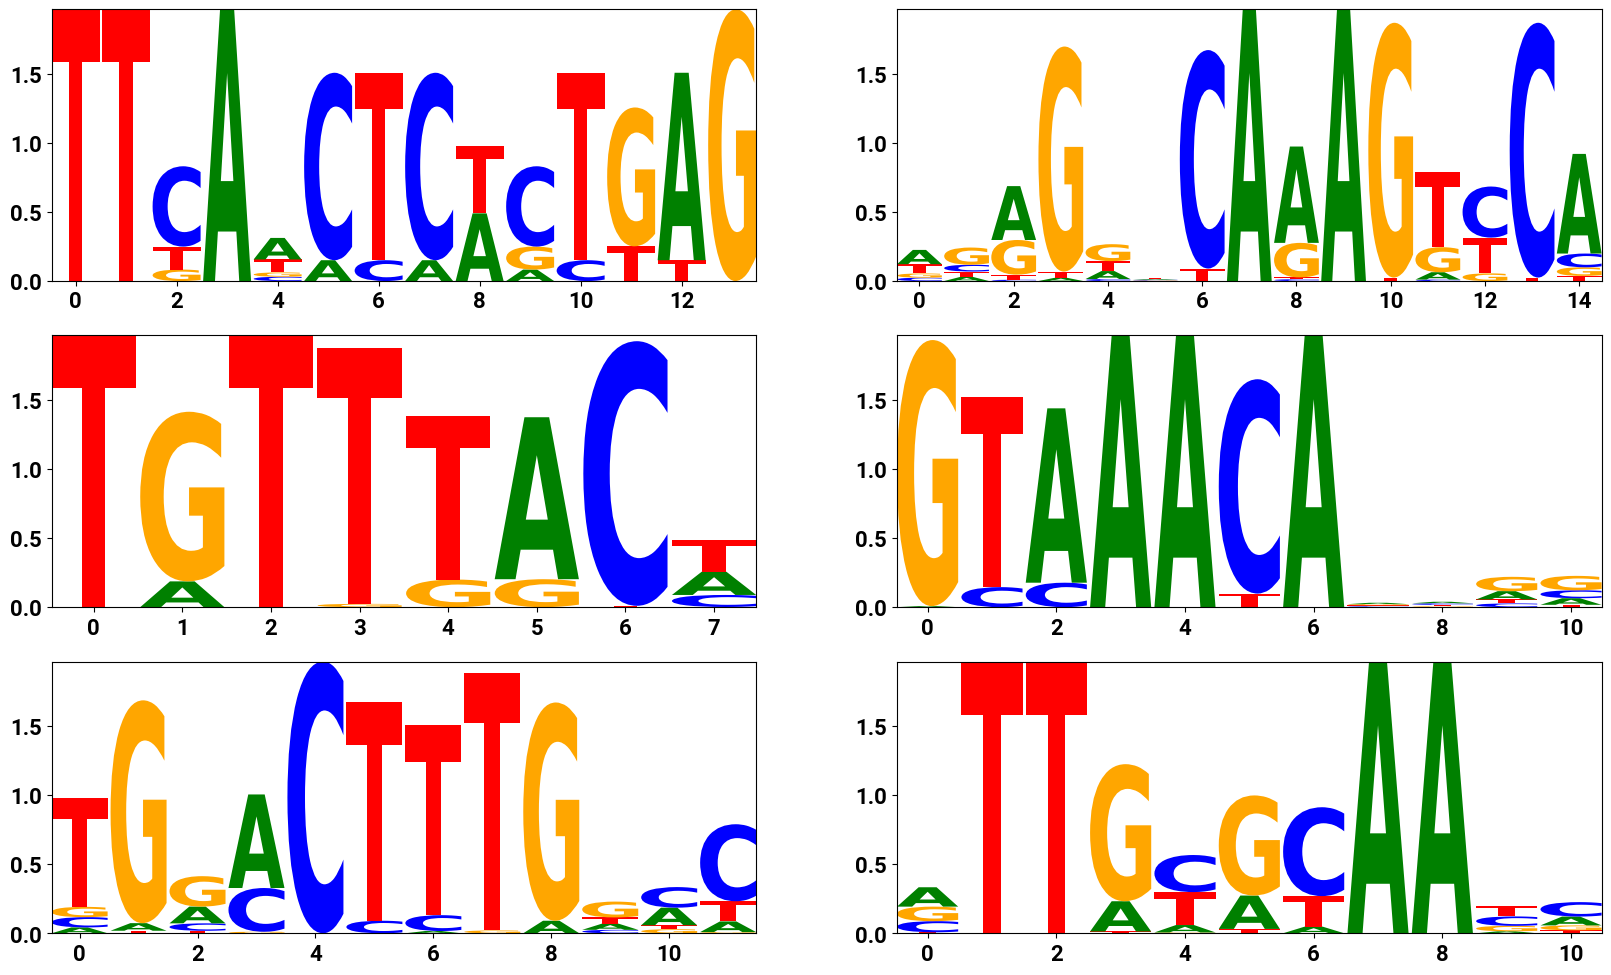

MAX (HepG2)


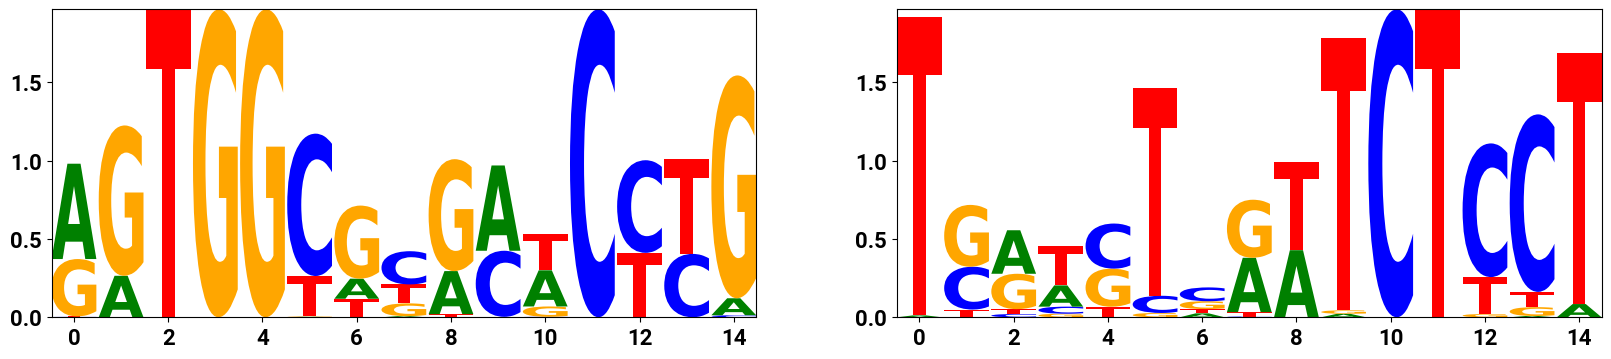

DNase (HepG2)


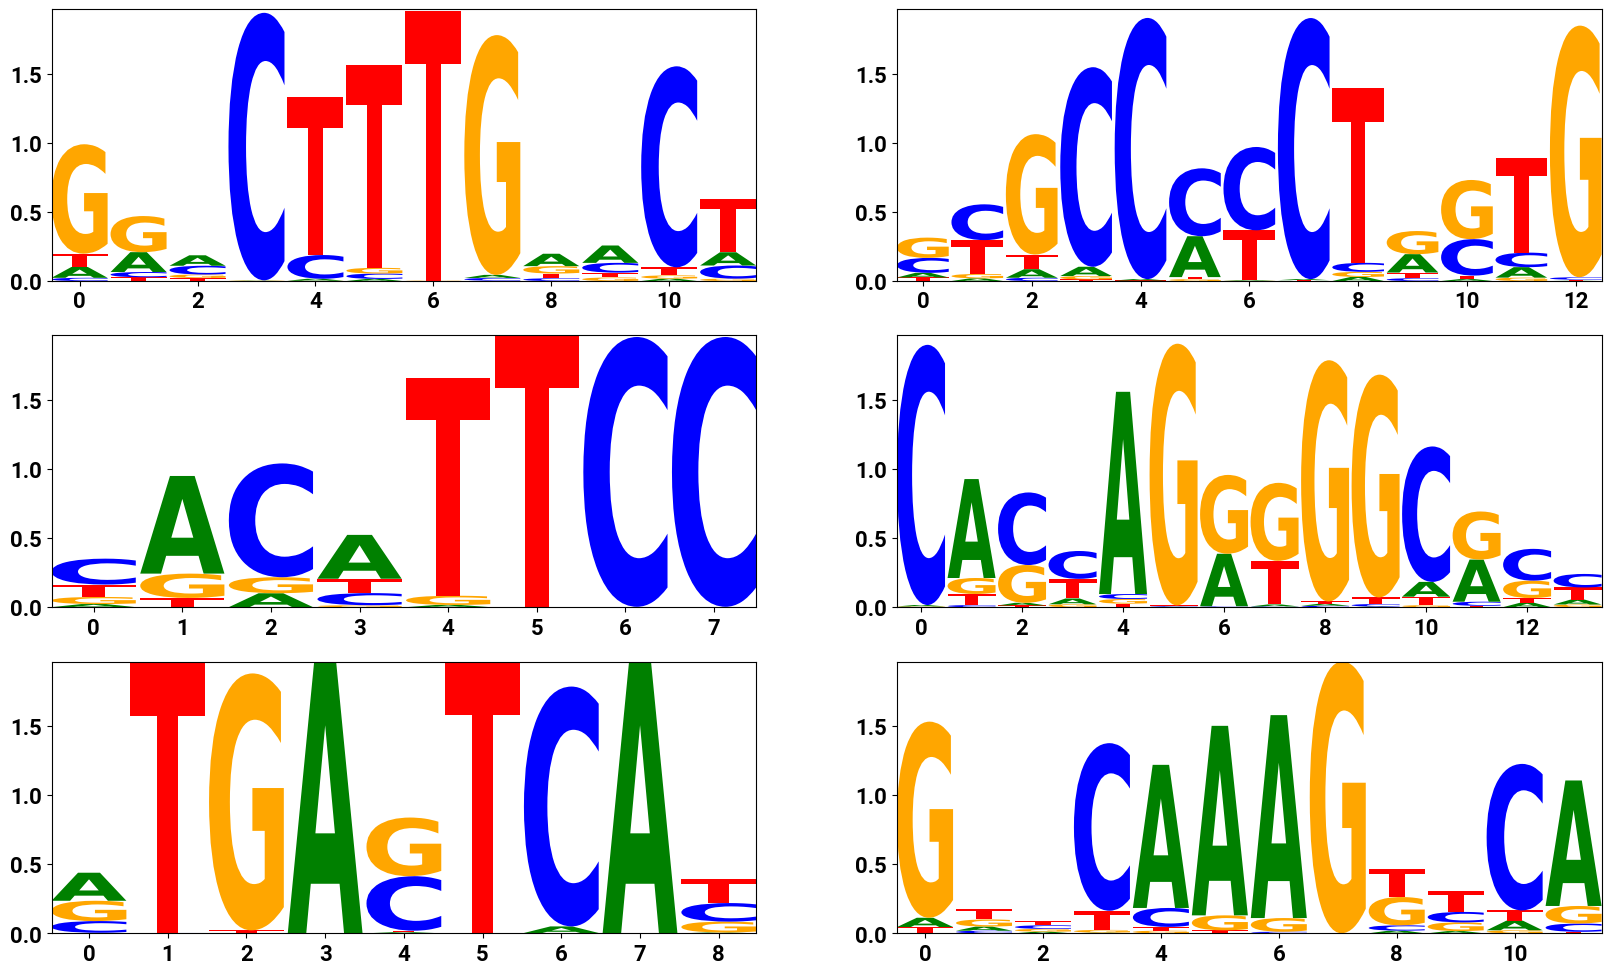

DNase (K562)


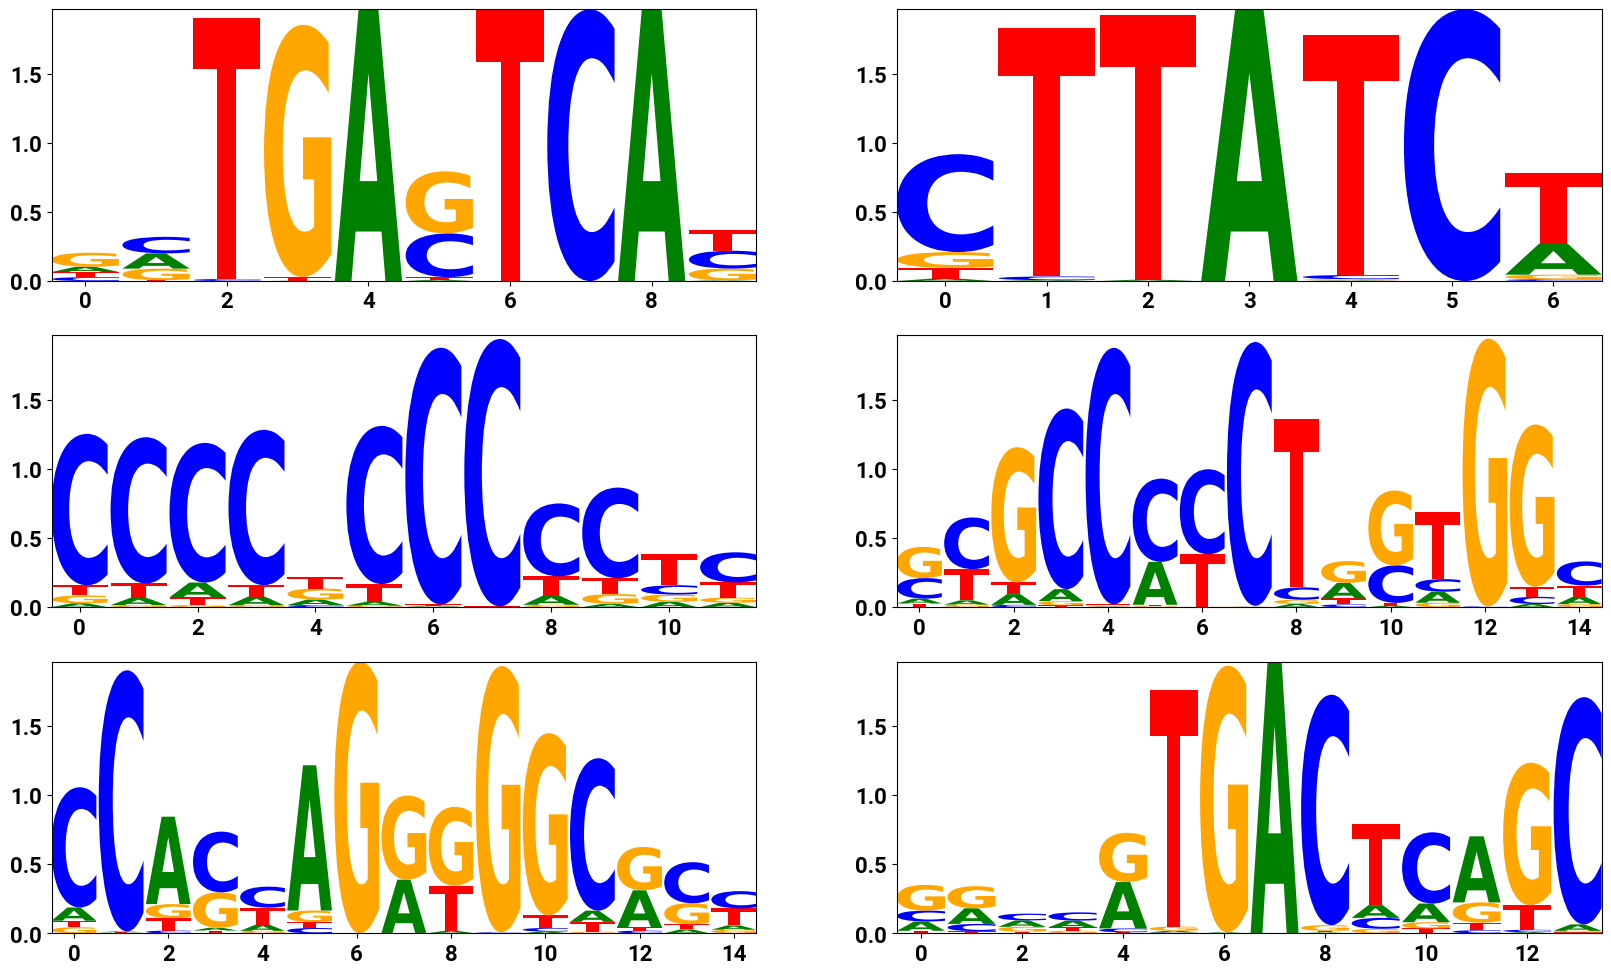

In [13]:
for dataset_key in datasets:
    print(dataset_key)
    plot_motifs.plot_motif_grid([pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in all_passed_pfms[dataset_key].values()])
    plt.show()

### Extract attention scores and profiles

In [14]:
# For each input coordinate, extract the associated BigWig profile
all_profiles = {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    profiles = []
    with pyBigWig.open(profile_bigwig_paths[dataset_key]) as f:
        for chrom, start, end in all_input_coords[dataset_key]:
            profiles.append(np.array(f.values(chrom, start, end)))
    f.close()
    all_profiles[dataset_key] = np.stack(profiles)

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
# Collapse attention scores and limit to those which were high enough and which
# are underlied by a high-enough filter activation of a passed PFM
all_att_scores_flat = {}

att_score_thresh = 0.5  # Zero out anything below this
conv_act_max_frac_thresh = 0.5  # Zero out anything which didn't map to activation at least this much of the max

for dataset_key in tqdm.notebook.tqdm(datasets):
    conv_acts = all_conv_acts[dataset_key]  # Shape: B x L' x F
    att_scores_flat = np.max(all_att_vals[dataset_key], axis=(1, 2))  # Shape: B x L'
    
    passed_inds = np.array(list(all_passed_pfms[dataset_key].keys()))  # Indices of filters we care about
    
    # Minimum convolutional activation threshold for each filter, infinity for filters not passed
    act_threshes = np.full(conv_acts.shape[2], np.inf)
    act_threshes[passed_inds] = (conv_act_max_frac_thresh * np.max(conv_acts, axis=(0, 1)))[passed_inds]
    
    passed_locs = np.any(conv_acts > act_threshes[None, None], axis=2)  # Shape: B x L'
    
    att_scores_flat[~passed_locs] = 0  # Zero out anything that didn't pass
    
    all_att_scores_flat[dataset_key] = att_scores_flat

  0%|          | 0/5 [00:00<?, ?it/s]

### Plot attention scores and profiles

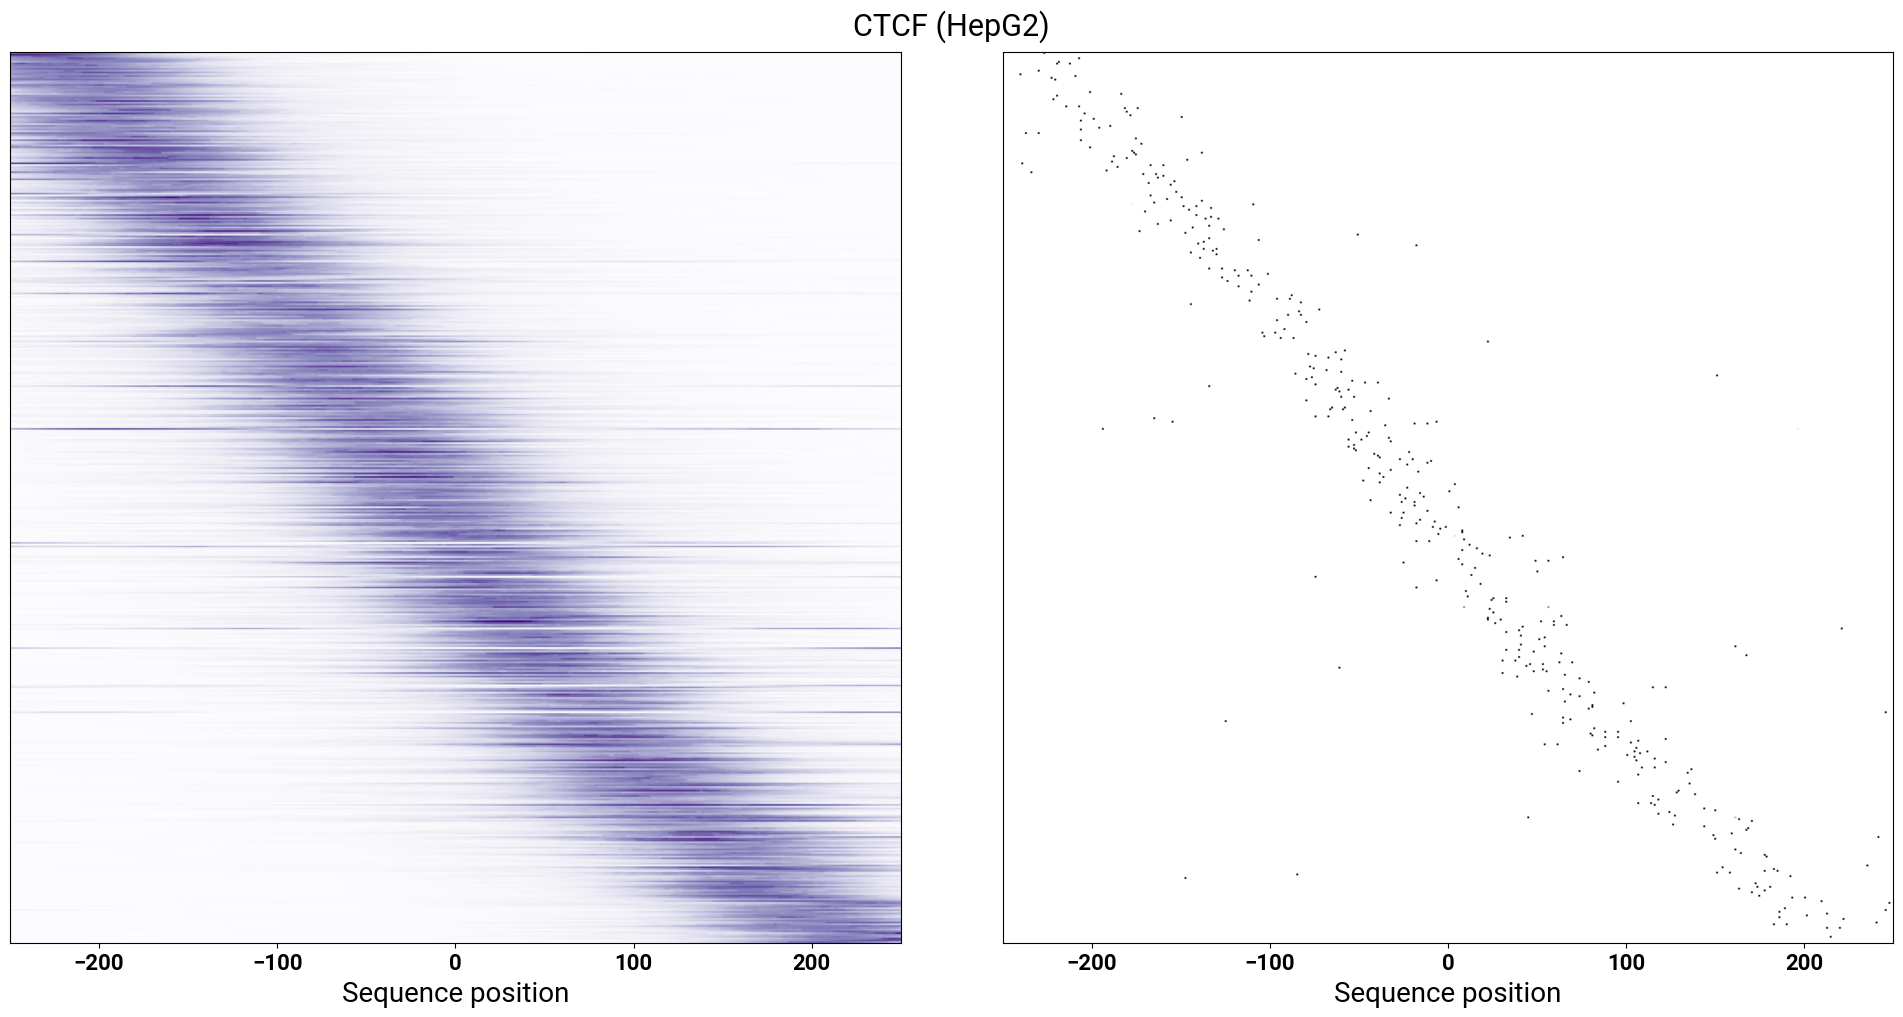

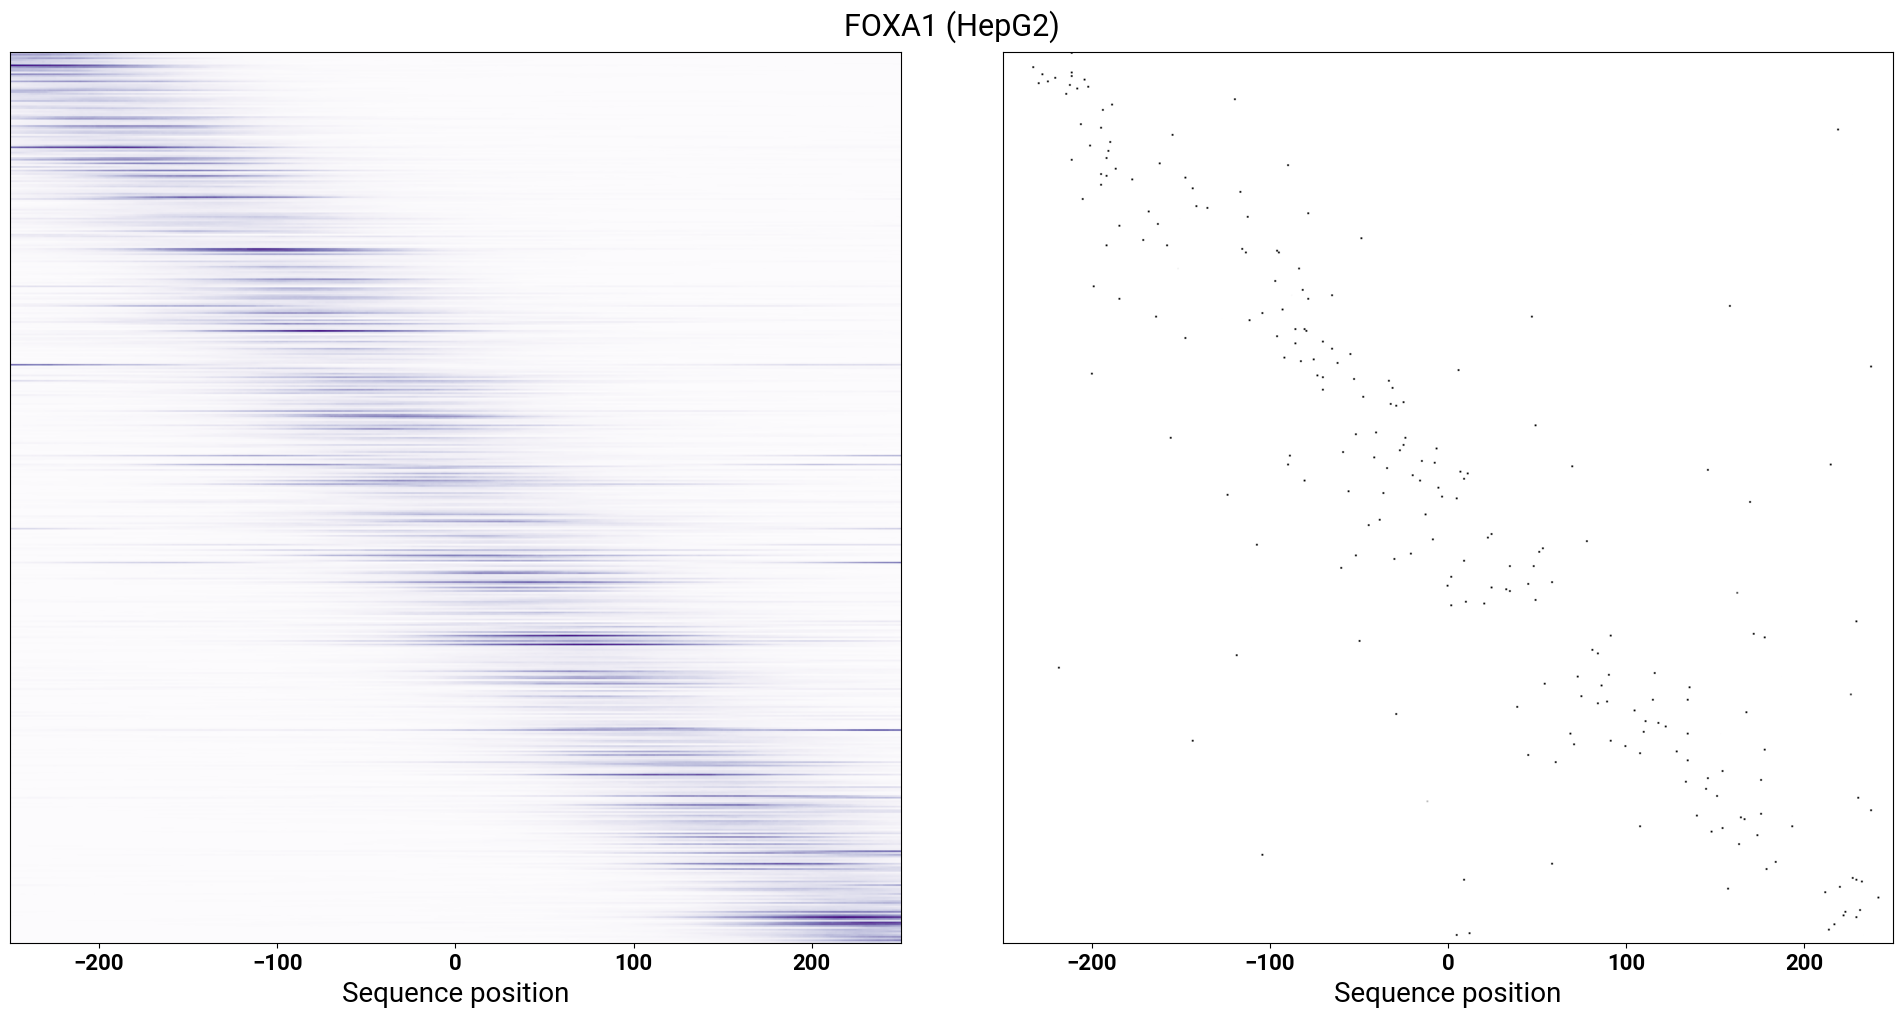

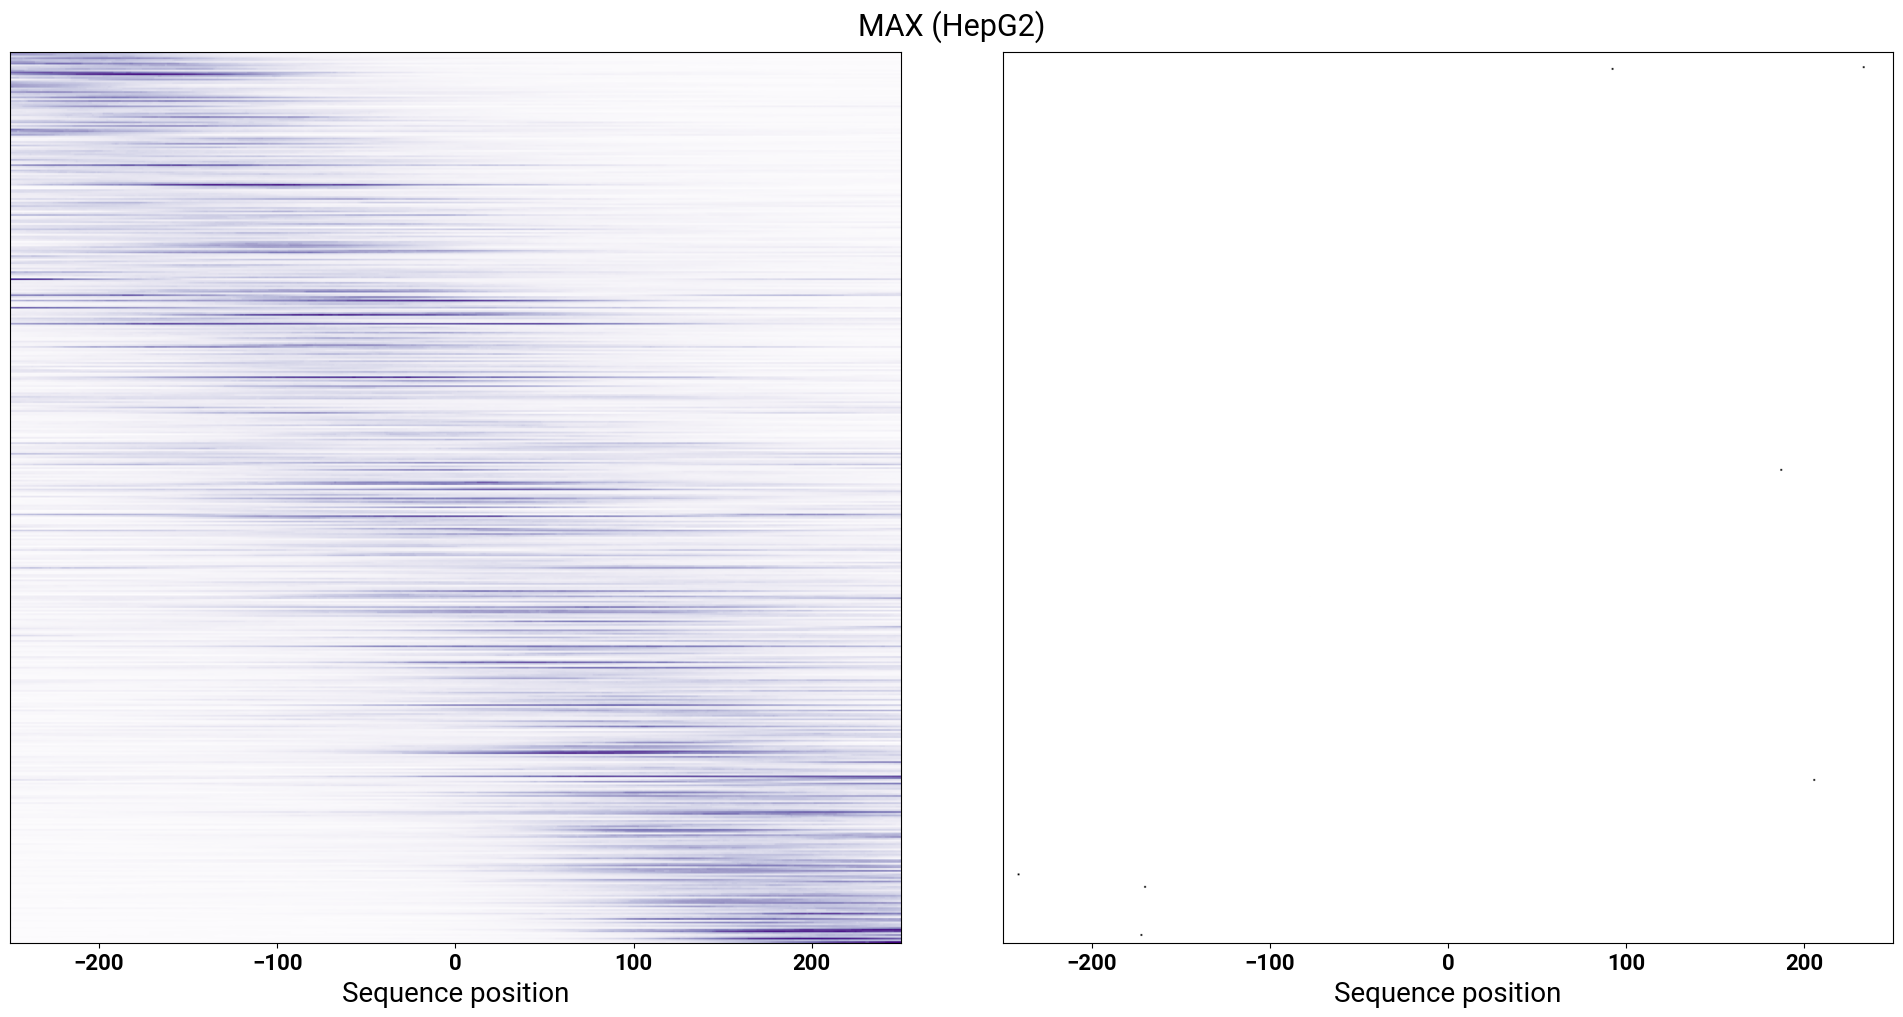

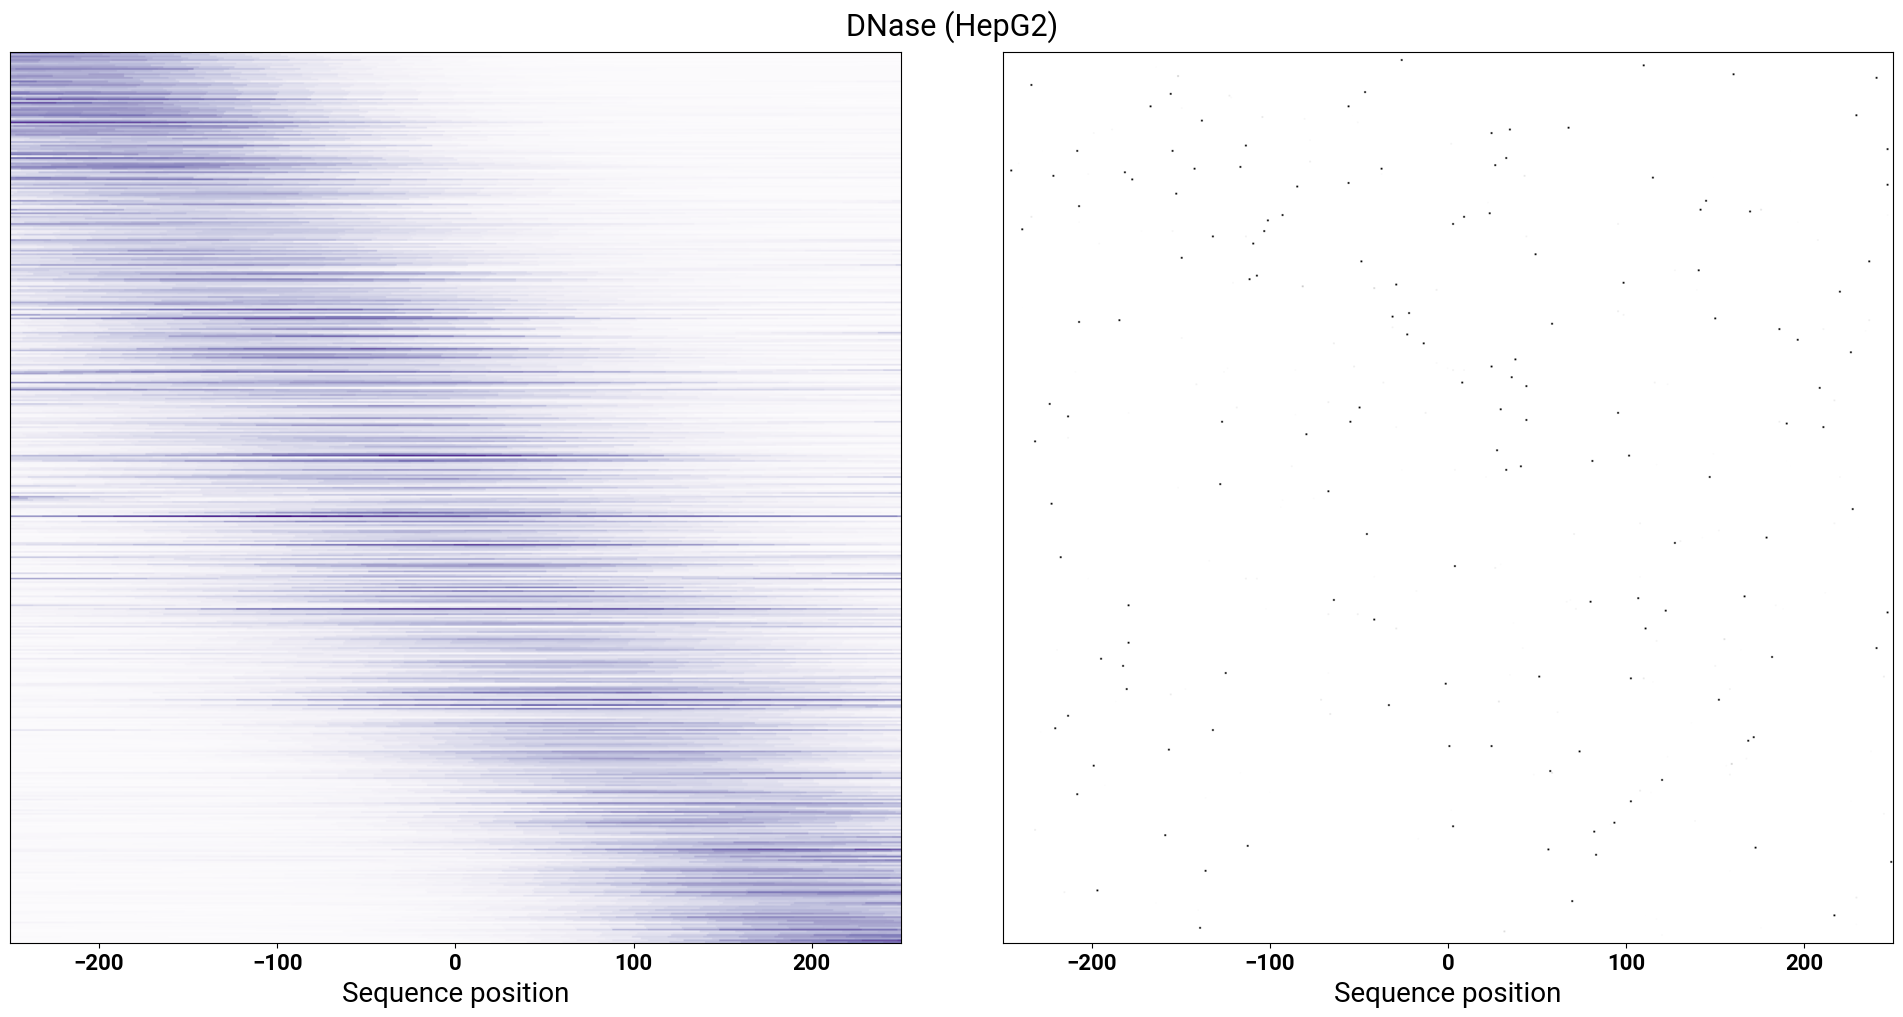

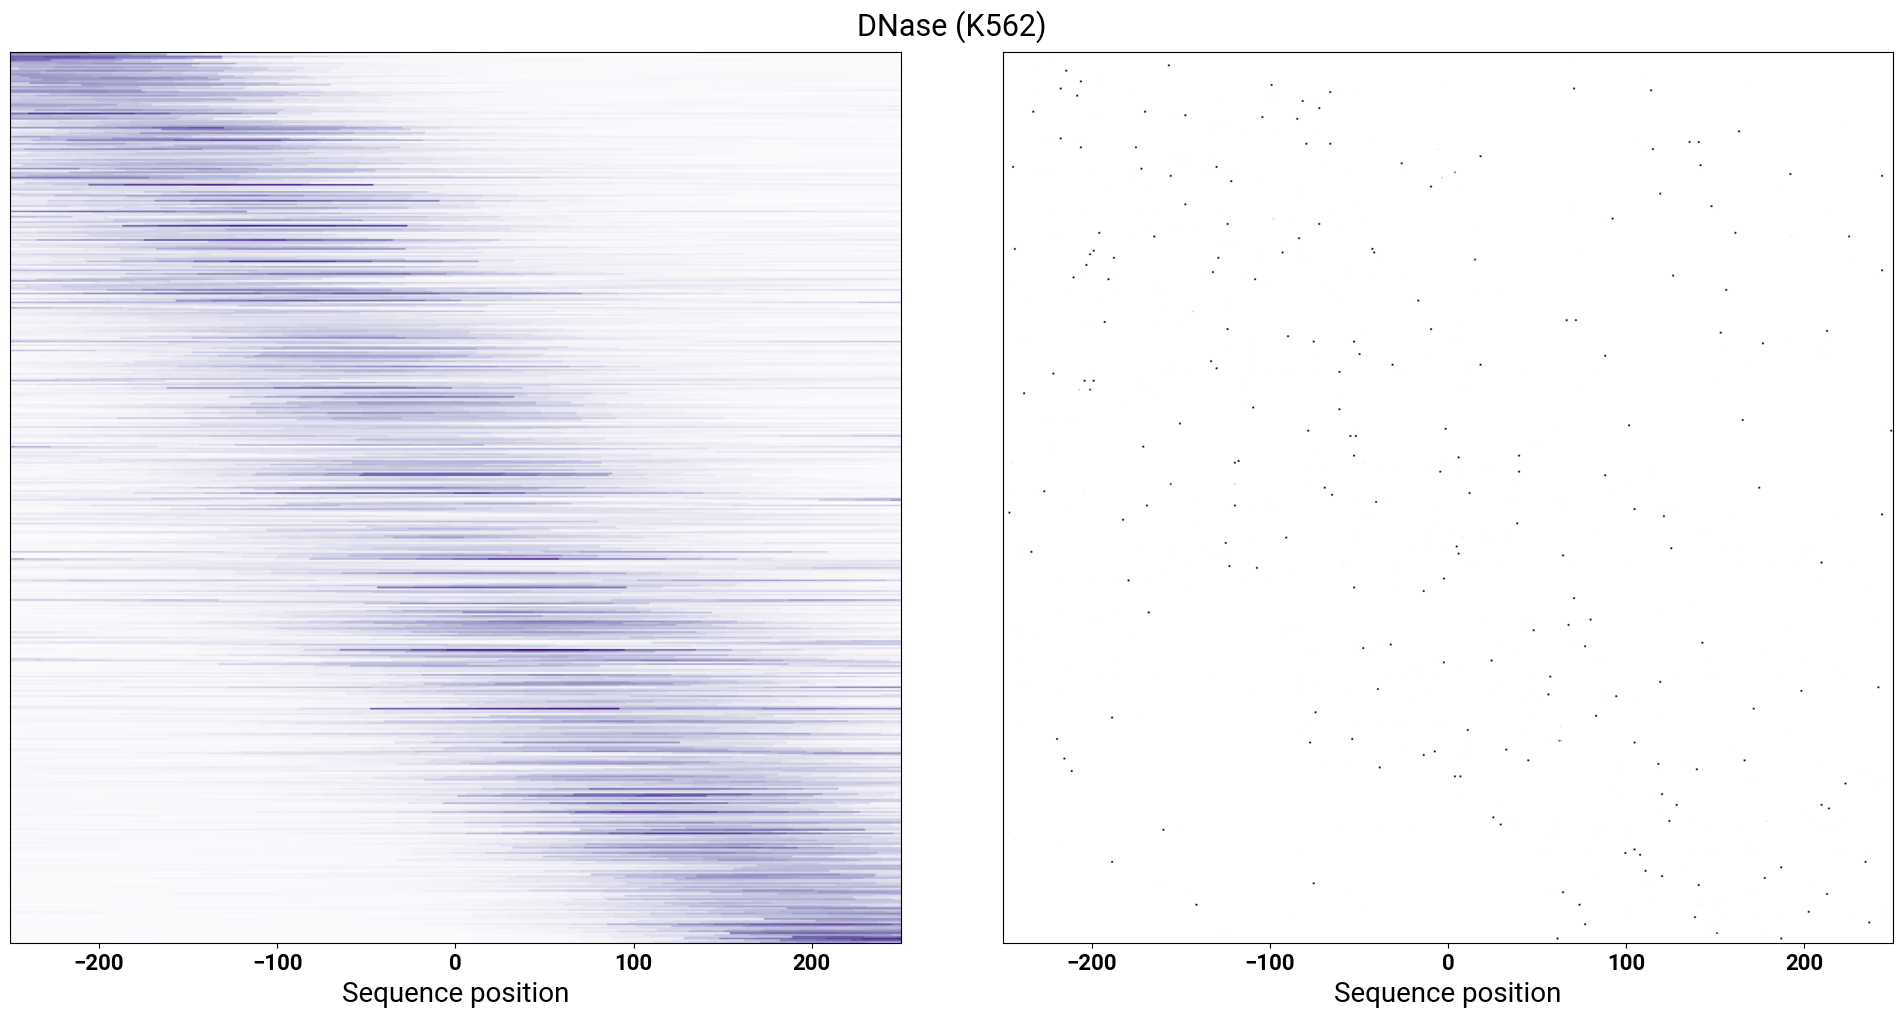

In [16]:
top_k = 500
for dataset_key in datasets:
    # Get indices of top sequences by signal strength
    top_inds = np.flip(np.argsort(np.sum(all_profiles[dataset_key], axis=1)))[:top_k]

    # Limit profiles and attention scores to top sequences by signal strength
    top_profiles = all_profiles[dataset_key][top_inds]
    top_att_scores = all_att_scores_flat[dataset_key][top_inds]

    # Resample and fit Gaussian mean
    top_profiles_dists = top_profiles / np.sum(top_profiles, axis=1, keepdims=True)
    means = np.array([
        scipy.stats.norm.fit(np.random.choice(np.arange(len(dist)), p=dist, size=10000))[0]
        for dist in top_profiles_dists
    ])

    # Order sequences by fitted mean
    sorted_inds = np.argsort(means)

    input_len = all_profiles[dataset_key].shape[1]
    x_min = -(input_len // 2)
    x_max = x_min + input_len
    y_min, y_max = 0, len(top_inds)
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
    ax[0].imshow(top_profiles[sorted_inds], extent=[x_min, x_max, y_min, y_max], cmap="Purples")
    ax[1].imshow(top_att_scores[sorted_inds], extent=[x_min, x_max, y_min, y_max], cmap="binary")
    for i in range(2):
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])
        ax[i].set_xlabel("Sequence position")
    fig.suptitle(dataset_key)
    fig.tight_layout()
    fig.savefig(os.path.join(figures_out_path, datasets_sanit[dataset_key] + "_att_scores_peaks.svg"), format="svg")
    plt.show()